## DarkELF absorption notebook

This notebook is meant to illustrate how to use DarkELF to calculate dark photon absorption rates.

written by Tongyan Lin & Simon Knapen, 04/20/2021

In [2]:
%matplotlib inline

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# uses matplotlib-label-lines, see for example https://github.com/cphyc/matplotlib-label-lines
#from labellines import labelLine, labelLines

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

from darkelf import darkelf, targets

Most materials come with grids for both phonon ELFs and electronic ELFs:

In [3]:
targets.files("Si")

Available configuration files: 
	 Si.yaml
 
Available data for epsilon: 
	 Si_Migdal_FAC.dat
	 Si_mermin.dat
	 Si_gpaw_noLFE.dat
	 Si_gpaw_withLFE.dat
	 Si_epsphonon_theory6K.dat
	 Si_epsphonon_data6K.dat
 
Available data for phonon (partial) density of states: 
	 Si_pDoS.dat
 
Available data for Fn(omega) functions: 
	 Si_Fn.dat
 
Available data for form factors: 
	 Si_atomic_Zion.dat
	 Si_Zion.dat


## Example

To make use of phonon processes, a phonon ELF file has to be specified using the "phonon_filename" flag:

In [4]:
si = darkelf(mX=1e1,target='Si',filename='Si_gpaw_noLFE.dat',phonon_filename="Si_epsphonon_data6K.dat")

 .... Loading files for Si
Loaded Si_gpaw_noLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method,Journal of Physics:Condensed Matter22(2010) 253202.
phonon ELF taken or calculated from M. Ikezawa and M. Ishigame, Far-Infrared AbsorptionDue to the Two-Phonon Difference Process in Si, Journal of the Physical Society of Japan 50(1981) 3734.
Loaded Si_epsphonon_data6K.dat for epsilon in phonon regime
Warning, Si_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onli

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Si/Si_pDoS_anisotropic.dat for partial densities of states
Si_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Si/Si_Fn.npy
Loaded Si_Fn_anisotropic.npy for Fn(omega)


In [5]:
?si.R_absorption

Signature: si.R_absorption(kappa=1e-15)
Docstring:
Returns rate for dark photon absorption, events per 1/kg/yr. Will use electronic ELF for mX > electronic band gap and phonon ELF otherwise. If the required ELF is not loaded or if mX is outside the range of the grid, the function will return zero.
Inputs
------
kappa: float
    kinetic mixing parameter for dark photon model
Outputs
-------
absorption rate [1/kg/yr]
File:      ~/Dropbox/Projects/DarkELF/darkelf/absorption.py
Type:      method

In [6]:
print(si.R_absorption(kappa=1.0))

8.067874215350231e+32


Simple function to extract a limit, assuming 3.6 events

In [7]:
def kappa_limit(target,mX):
    scalar_input = np.isscalar(mX)
    mXlist = np.atleast_1d(mX)
    lim=[]
    
    for mX in mXlist:
        target.update_params(mX=mX)
        rate=target.R_absorption(kappa=1.0)
        if rate==0.0:
            lim.append(np.nan)
        else:
            lim.append(np.sqrt(3.0/rate))
            
    if(scalar_input):
        return lim[0]
    else:
        return np.array(lim) 

In [8]:
# electron regime
print(kappa_limit(si,10.0))

# phonon regime
print(kappa_limit(si,0.1))

6.09791081165515e-17
8.475403123945507e-15


# Plot with many targets

In [10]:
ge = darkelf(target='Ge',filename='Ge_gpaw_noLFE.dat',phonon_filename="Ge_epsphonon_data2K.dat")
simermin = darkelf(target='Si',filename='Si_mermin.dat',phonon_filename="Si_epsphonon_data6K.dat")
gemermin = darkelf(target='Ge',filename='Ge_mermin.dat',phonon_filename="Ge_epsphonon_data2K.dat")

GaAs = darkelf(target='GaAs',filename="GaAs_mermin.dat",phonon_filename="GaAs_epsphonon_data10K.dat")

GaN = darkelf(target='GaN',filename="GaN_mermin.dat",phonon_filename="GaN_epsphonon_300K.dat")

Al = darkelf(target='Al',filename="Al_mermin.dat")

SiO2 = darkelf(target='SiO2',filename="SiO2_mermin.dat",phonon_filename="SiO2_epsphonon_o.dat")
SiO2_e = darkelf(target='SiO2',targetyaml='SiO2_extraordinary',
                 filename="SiO2_mermin.dat",phonon_filename="SiO2_epsphonon_e.dat")

SiC = darkelf(target='SiC',phonon_filename="SiC_epsphonon_3C.dat")
ZnS = darkelf(target='ZnS',filename="ZnS_mermin.dat",phonon_filename="ZnS_epsphonon_300K.dat")

Al2O3 = darkelf(target='Al2O3',filename="Al2O3_mermin.dat",phonon_filename="Al2O3_epsphonon_o.dat")
Al2O3_e = darkelf(target='Al2O3',targetyaml='Al2O3_extraordinary',filename="Al2O3_mermin.dat",phonon_filename="Al2O3_epsphonon_e.dat")


Anisotropic calculations unavailable for Ge
 .... Loading files for Ge
Loaded Ge_gpaw_noLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method,Journal of Physics:Condensed Matter22(2010) 253202.


/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


phonon ELF taken or calculated from M. Ikezawa and T. Nanba, Two-Phonon Difference Absorption Spectra in Ge Crystals, Journal of  the Physical Society of Japan 45 (1978) 148.
Loaded Ge_epsphonon_data2K.dat for epsilon in phonon regime
Warning, Ge_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Ge/Ge_pDoS.dat for partial densities of states
Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Ge/Ge_Fn.dat for Fn(omega)
 .... Loading files for Si
Loaded Si_mermin.d

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Si/Si_pDoS_anisotropic.dat for partial densities of states
Si_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Si/Si_Fn.npy
Loaded Si_Fn_anisotropic.npy for Fn(omega)
Anisotropic calculations unavailable for Ge
 .... Loading files for Ge
Loaded Ge_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from M. Nov ́ak, L. K ̈ov ́er, S. Egri, I. Cserny, J. T ́oth, D. Varga et al., A simple statistical model for quantitative analysis of plasmon structures in xps and auger spectra of free-electron-like materials,Journal ofElectron Spectroscopy and Related Phenomena163(2008) 7
phonon ELF taken or calculated from M. Ikezawa and T. Nanba, Two-Phonon Difference Absorption Spectra in Ge Crystals, Journal of  the Physical Society of Japan 45 (1978) 148.
Loaded Ge_epsphonon_data2K.dat for epsilon in phonon regime
Warning, Ge_eps_electron_opticallimit.dat does no

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from H.M. Lawler and E.L. Shirley, Anharmonic effects on infrared spectra of GaAs and gap:  First-principles calculations, Phys. Rev. B70(2004) 245209 and E.D. Palik, Gallium arsenide (gaas), in Handbook of Optical Constants of Solids, E.D. Palik, ed.,pp. 429–443, Elsevier (1985).
Loaded GaAs_epsphonon_data10K.dat for epsilon in phonon regime
Warning, GaAs_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Warning! Atomic Migdal calculation not present
Warning! Momentum dependent Zion for Migdal calculation not loaded. Using Z - number of valence electrons.
Loaded /Users/tongyan/D

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_pDoS_anisotropic.dat for partial densities of states
GaAs_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_Fn.npy
Warning! GaAs_Fn_anisotropic.npy does not exist! Need to calculate Fn(omega) from DoS. Use the function 'F_n_d_precompute' to produce these files 
Anisotropic calculations unavailable for GaN
 .... Loading files for GaN
Loaded GaN_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from G. Yu, N.L. Rowell and D.J. Lockwood, Anisotropic infrared optical properties of gan and sapphire, Journal of Vacuum Science & Technology A22(2004) 1110[https://doi.org/10.1116/1.1752891]
Loaded GaN_epsphonon_300K.dat for epsilon in phonon re

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Anisotropic calculations unavailable for Al
 .... Loading files for Al
Loaded Al_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Sun, H. Xu, B. Da, S.-f. Mao and Z.-j. Ding, Calculations of Energy-Loss Function for 26 Materials, Chinese Journal of Chemical Physics9(2016) 663.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename to perform data-driven, single phonon calculations
Warning, Al_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Warning! Atomic Migdal calculation not present
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
Loaded /Users/to

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


 .... Loading files for SiO2
Loaded SiO2_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Sun, H. Xu, B. Da, S.-f. Mao and Z.-j. Ding, Calculations of Energy-Loss Function for 26 Materials, Chinese Journal of Chemical Physics9(2016) 663.
phonon ELF taken or calculated from 
Loaded SiO2_epsphonon_o.dat for epsilon in phonon regime
Warning, SiO2_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Warning! Atomic Migdal calculation not present
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/SiO2/Si_pDoS

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/SiO2/SiO2_pDoS_anisotropic.dat for partial densities of states
SiO2_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/SiO2/SiO2_Fn.npy
Loaded SiO2_Fn_anisotropic.npy for Fn(omega)
 .... Loading files for SiO2
Loaded SiO2_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Sun, H. Xu, B. Da, S.-f. Mao and Z.-j. Ding, Calculations of Energy-Loss Function for 26 Materials, Chinese Journal of Chemical Physics9(2016) 663.
phonon ELF taken or calculated from F. Gervais and B. Piriou, Temperature dependence of transverse and longitudinal optic modes in the α and β phases of quartz, Phys. Rev. B11(1975) 3944  
Loaded SiO2_epsphonon_e.dat for epsilon in phonon regime
Warning, SiO2_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Warning! Atomic Migdal

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


 .... Loading files for Al2O3
Loaded Al2O3_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Sun, H. Xu, B. Da, S.-f. Mao and Z.-j. Ding, Calculations of Energy-Loss Function for 26 Materials, Chinese Journal of Chemical Physics9(2016) 663.
phonon ELF taken or calculated from  F. Gervais and B. Piriou, Anharmonicity in several-polar-mode crystals:  adjusting phonon self-energy of LO and TO modes in Al2O3 and TiO2 to fit infrared reflectivity,Journal of Physics C Solid State Physics 7 (1974) 2374 and M. Schubert, T.E. Tiwald and C.M. Herzinger, Infrared dielectric anisotropy and phonon modes of sapphire, Phys. Rev. B61(2000) 8187
Loaded Al2O3_epsphonon_o.dat for epsilon in phonon regime
Warning, Al2O3_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Warning! Atomic Migdal calculation not present
Warning! Momentum dependent Zion for Migdal calculation no

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Al2O3/Al2O3_pDoS_anisotropic.dat for partial densities of states
Al2O3_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Al2O3/Al2O3_Fn.npy
Loaded Al2O3_Fn_anisotropic.npy for Fn(omega)
 .... Loading files for Al2O3
Loaded Al2O3_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Sun, H. Xu, B. Da, S.-f. Mao and Z.-j. Ding, Calculations of Energy-Loss Function for 26 Materials, Chinese Journal of Chemical Physics9(2016) 663.
phonon ELF taken or calculated from  F. Gervais and B. Piriou, Anharmonicity in several-polar-mode crystals:  adjusting phonon self-energy of LO and TO modes in Al2O3 and TiO2 to fit infrared reflectivity,Journal of Physics C Solid State Physics 7 (1974) 2374 and M. Schubert, T.E. Tiwald and C.M. Herzinger, Infrared dielectric anisotropy and phonon modes of sapphire, Phys. Rev. B61(2000) 8187
Loaded Al2O3_epsphonon_e.dat

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Al2O3/Al2O3_pDoS_anisotropic.dat for partial densities of states
Al2O3_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Al2O3/Al2O3_Fn.npy
Loaded Al2O3_Fn_anisotropic.npy for Fn(omega)


For Ge, there are some unphysical wiggles at high omega. This due to a numerical artifact when converting the Novak et al parametrization to the Mermin model. We smooth this out by fitting the rate to a smooth polynomial:

/Users/ethanvillarama/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3361: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


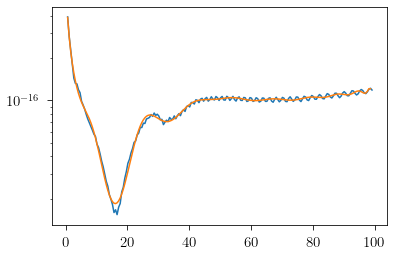

In [8]:
mVelectron = np.linspace(gemermin.E_gap,100,200)
mVphonon = np.linspace(.03,.08,100)
a = kappa_limit(gemermin,mVelectron)

fitparam=np.polyfit(mVelectron[:-3],np.log10(a)[:-3],30)
aa = (lambda mV: 10**np.poly1d(fitparam)(mV))

plt.plot(mVelectron,a,label='Ge')
plt.plot(mVelectron[:-3],list(map(aa,mVelectron[:-3])),label='Ge')
plt.yscale("log")
plt.show()


/var/folders/rg/bnkv6w611wd9wt6wb3m9n5mm0000gn/T/ipykernel_87743/4228469574.py:12: RuntimeWarning: invalid value encountered in sqrt
  lim.append(np.sqrt(3.0/rate))
/Users/ethanvillarama/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3361: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


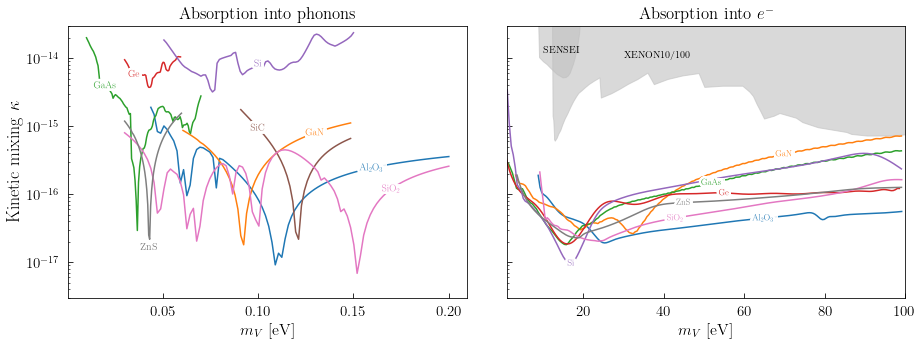

In [9]:
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0.0,1.0,10))

fig, axs = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.subplots_adjust(wspace=0.1)

props = dict(facecolor='white', alpha=0.9, edgecolor='white',boxstyle="square,pad=0.025")

# Al2O3
mVelectron = np.linspace(Al2O3.E_gap,100,200)
mVphonon = np.linspace(.03,.2,100)
a = kappa_limit(Al2O3,mVelectron)
axs[1].plot(mVelectron,a,color=colors[0],label=r'Al$_2$O$_3$')
b1 = kappa_limit(Al2O3,mVphonon)
b2 = kappa_limit(Al2O3_e,mVphonon)
b = pow(1./3*1./b1**2 + 2./3*1./b2**2,-0.5)
axs[0].plot(mVphonon,b,color=colors[0],label=r'Al$_2$O$_3$')

# GaN
mVelectron = np.linspace(GaN.E_gap,100,200)
mVphonon = np.linspace(.05,.2,100)
a = kappa_limit(GaN,mVelectron)
axs[1].plot(mVelectron,a,color=colors[1],label='GaN')
b = kappa_limit(GaN,mVphonon)
axs[0].plot(mVphonon,b,color=colors[1],label='GaN')

# GaAs
mVelectron = np.linspace(GaAs.E_gap,100,200)
mVphonon = np.linspace(.01,.07,100)
a = kappa_limit(GaAs,mVelectron)
axs[1].plot(mVelectron,a,color=colors[2],label='GaAs')
b = kappa_limit(GaAs,mVphonon)
axs[0].plot(mVphonon,b,color=colors[2],label='GaAs')


# Ge
mVelectron = np.linspace(gemermin.E_gap,100,200)
mVphonon = np.linspace(.03,.08,100)
a = kappa_limit(gemermin,mVelectron)
fitparam=np.polyfit(mVelectron[:-3],np.log10(a)[:-3],30) # need to smooth out Ge curve, due to numerical artifact
aa = (lambda mV: 10**np.poly1d(fitparam)(mV))
axs[1].plot(mVelectron[:-3],list(map(aa,mVelectron[:-3])),color=colors[3],label='Ge')
b = kappa_limit(gemermin,mVphonon)
axs[0].plot(mVphonon,b,color=colors[3],label='Ge')

# SI
mVelectron = np.linspace(simermin.E_gap,100,200)
mVphonon = np.linspace(.03,.15,100)
a = kappa_limit(simermin,mVelectron)
axs[1].plot(mVelectron,a,color=colors[4],label='Si')
b = kappa_limit(simermin,mVphonon)
axs[0].plot(mVphonon,b,color=colors[4],label='Si')

# SIC
mVphonon = np.linspace(.05,.2,100)
b = kappa_limit(SiC,mVphonon)
axs[0].plot(mVphonon,b,color=colors[5],label='SiC')

# SIO2
mVelectron = np.linspace(SiO2.E_gap,100,200)
mVphonon = np.linspace(.03,.2,100)
a = kappa_limit(SiO2,mVelectron)
axs[1].plot(mVelectron,a,color=colors[6],label=r'SiO$_2$')
b1 = kappa_limit(SiO2,mVphonon)
b2 = kappa_limit(SiO2_e,mVphonon)
b = pow(1./3*1./b1**2 + 2./3*1./b2**2,-0.5)
axs[0].plot(mVphonon,b,color=colors[6],label=r'SiO$_2$')

# ZnS
mVelectron = np.linspace(ZnS.E_gap,100,200)
mVphonon = np.linspace(.03,.08,100)
a = kappa_limit(ZnS,mVelectron)
axs[1].plot(mVelectron,a,color=colors[7],label='ZnS')
b = kappa_limit(ZnS,mVphonon)
axs[0].plot(mVphonon,b,color=colors[7],label='ZnS')

### Plot settings for left panel
axs[0].set_yscale('log')
axs[0].set_ylim([3e-18,3e-14])
axs[0].tick_params(direction='in',which='both',pad=8)
axs[0].set_xlabel(r'$m_V$ [eV]',fontsize=16)
axs[0].set_ylabel(r'Kinetic mixing $\kappa$',fontsize=18)

lines = axs[0].get_lines()
labelLines(lines,xvals=[0.16,0.13,.02,0.035,0.1,0.1,0.17],fontsize=10,zorder=2.5,
           ha='center',va='center',align=False,bbox=props)
axs[0].text(0.038,1.5e-17,r'ZnS',color=colors[7],fontsize=10,bbox=props)
axs[0].set_title('Absorption into phonons')

### Plot settings for right panel

dat = np.loadtxt('data/kappa_limit_xenon.txt').T
axs[1].fill_between(dat[0],dat[1],dat[1]*0.0+1e-13,color='Silver',alpha=0.6)
dat = np.loadtxt('data/kappa_limit_SENSEI2020.txt').T
axs[1].fill_between(dat[0],dat[1],dat[1]*0.0+1e-13,color='Silver',alpha=0.6)
axs[1].text(30,1e-14,'XENON10/100',fontsize=10)
axs[1].text(10,1.2e-14,'SENSEI',fontsize=10)

axs[1].set_xlim([1.0,100])
axs[1].tick_params(direction='in',which='both',pad=8)
axs[1].set_xlabel(r'$m_V$ [eV]',fontsize=16)

lines = axs[1].get_lines()
labelLines(lines,xvals=[65,70,52,55,17,43,45],fontsize=9,zorder=2.5,
           ha='center',va='center',align=False,bbox=props)
axs[1].set_title('Absorption into $e^-$')

fig.savefig('plots/darkelf_absorption_1.pdf',bbox_inches='tight')

### The reach does not depend too much on how ordinary and extraordinary response are averaged

/var/folders/js/mqwdb5_s6yxc3gzsy7vwzl640000gn/T/ipykernel_59147/4228469574.py:12: RuntimeWarning: invalid value encountered in sqrt
  lim.append(np.sqrt(3.0/rate))


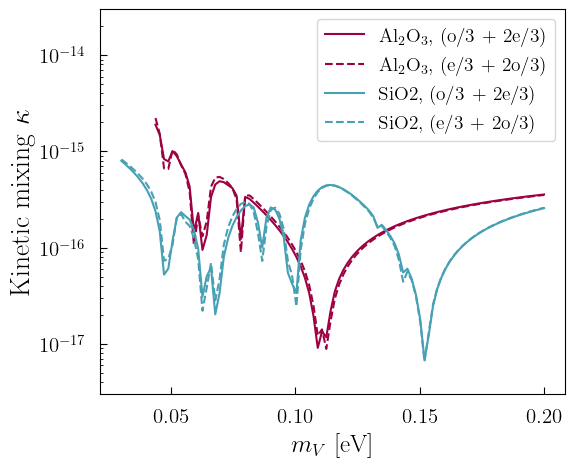

In [11]:
cmap = plt.get_cmap('Spectral')
colors = cmap(np.linspace(0.0,1.0,8))

fig, axs = plt.subplots(1,1,figsize=(6,5))

# Al2O3
mVphonon = np.linspace(.03,.2,100)
b1 = kappa_limit(Al2O3,mVphonon)
b2 = kappa_limit(Al2O3_e,mVphonon)
# 1/3 * ordinary + 2/3 * extraordinary
b = pow(1./3*1./b1**2 + 2./3*1./b2**2,-0.5)
axs.plot(mVphonon,b,color=colors[0],label=r'Al$_2$O$_3$, (o/3 + 2e/3)')
# 2/3 * ordinary + 1/3 * extraordinary
b = pow(2./3*1./b1**2 + 1./3*1./b2**2,-0.5)
axs.plot(mVphonon,b,color=colors[0],label=r'Al$_2$O$_3$, (e/3 + 2o/3)',linestyle='--')

# SIO2
mVphonon = np.linspace(.03,.2,100)
b1 = kappa_limit(SiO2,mVphonon)
b2 = kappa_limit(SiO2_e,mVphonon)
# 1/3 * ordinary + 2/3 * extraordinary
b = pow(1./3*1./b1**2 + 2./3*1./b2**2,-0.5)
axs.plot(mVphonon,b,color=colors[6],label='SiO2, (o/3 + 2e/3)')
# 2/3 * ordinary + 1/3 * extraordinary
b = pow(2./3*1./b1**2 + 1./3*1./b2**2,-0.5)
axs.plot(mVphonon,b,color=colors[6],label='SiO2, (e/3 + 2o/3)',linestyle='--')

### Plot settings for left panel
axs.set_yscale('log')
axs.set_ylim([3e-18,3e-14])
axs.tick_params(direction='in',which='both',pad=10)
axs.set_xlabel(r'$m_V$ [eV]',fontsize=18)
axs.set_ylabel(r'Kinetic mixing $\kappa$',fontsize=20)

axs.legend()
#fig.savefig('plots/darkelf_absorption_2.pdf',bbox_inches='tight')